# II. Camera model and homographies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from lib import box3d

In [2]:
def get_distorted(r, distortion_coefficients):
    """Return p(1 + dr(p))."""
    k3, k5, k7 = distortion_coefficients
    n = np.sqrt(r[0, :] ** 2 + r[1, :] ** 2)
    dr = k3 * n ** 2 + k5 * n ** 4 + k7 * n ** 6
    r[:2, :] = r[:2, :] * (1 + dr)
    return r


def projectpoints(K, R, t, Q, distortion_coeff=[0, 0, 0]):
    """Return the projected points as a 2xn matrix."""
    d, n = Q.shape
    if d == 3:
        Q = np.vstack([Q, np.ones(n)])
    T = np.hstack([R, t])

    r = T @ Q
    r = r[:2, :] / r[2, :]
    dist = get_distorted(r, distortion_coeff)
    P = K @ np.concatenate([dist, np.ones([1, n])], axis=0)
    return P

In [3]:
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400

K = np.array([[f, beta * f, dx], [0, alpha * f, dy], [0, 0, 1]])
R = np.eye(3)
t = np.array([[0, 0.2, 1.5]]).T

Q = box3d(16)

### 2.1 Without distortion

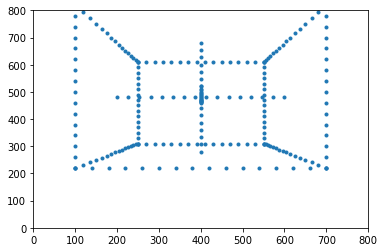

In [4]:
p2d = projectpoints(K, R, t, Q)

plt.plot(p2d[0], p2d[1], ".")
plt.xlim(0, 2 * dx)
plt.ylim(0, 2 * dy);

### 2.2 With distortion

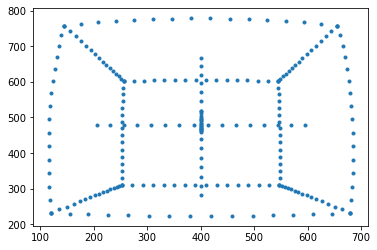

In [5]:
distortion = [-0.2, 0, 0]
p2d = projectpoints(K, R, t, Q, distortion_coeff=distortion)
  
plt.plot(p2d[0], p2d[1], ".")
# plt.xlim(0, 2 * dx)
# plt.ylim(0, 2 * dy);

### 2.3 GoPro

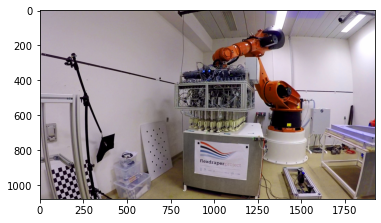

In [6]:
im = cv2.imread("data/gopro_robot.jpg")
b, g, r = cv2.split(im)
im = cv2.merge([r, g, b])

plt.imshow(im);

In [7]:
(h, w, d) = im.shape
f = 0.455732 * w
dx = h // 2
dy = w // 2
k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978
distortion = np.array([k3, k5, k7])

K = np.array([[f, beta * f, dx], [0, alpha * f, dy], [0, 0, 1]])
K.astype(int)

array([[875,   0, 540],
       [  0, 875, 960],
       [  0,   0,   1]])

### 2.4 Undistort the image
# I only get the correct result if I halve the distortion

In [8]:
def undistortImage(Image, K, distortion_coeff):
    """
    Parameters
    ----------
    Image:
        image
    K:
        camera matrix
    distortion_coeff:
        distortion coefficients

    Return
    ------
    An undistorted version of the image
    """
    h, w, d = Image.shape
    
    grid = np.ones([h * w, 3], dtype=int)
    columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
    grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()

    grid = np.linalg.inv(K) @ grid.T
    grid /= grid[2]
    
    grid = get_distorted(grid, distortion_coeff)
    grid = (K @ grid).T
    grid = grid.reshape(h, w, 3)[:, :, :2].astype(int)
    fig, ax = plt.subplots(1, 2, figsize=(20,20))
    ax[0].imshow(grid[:, :, 0])
    ax[1].imshow(grid[:, :, 1])
    
    points = (np.arange(0, h), np.arange(0, w))
    I_undistorted = np.zeros(Image.shape)
    for i in range(d):
        I = Image[:, :, i]
        interpolating_function = RegularGridInterpolator(
            points,
            values=I,
            method="nearest",
            bounds_error=False,
            fill_value=0
        )
        I_undistorted[:, :, i] = interpolating_function(grid)
    return I_undistorted.astype(int)

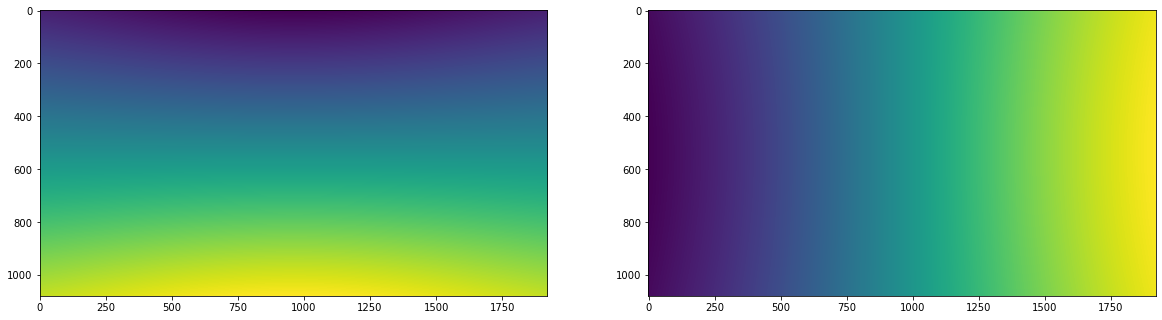

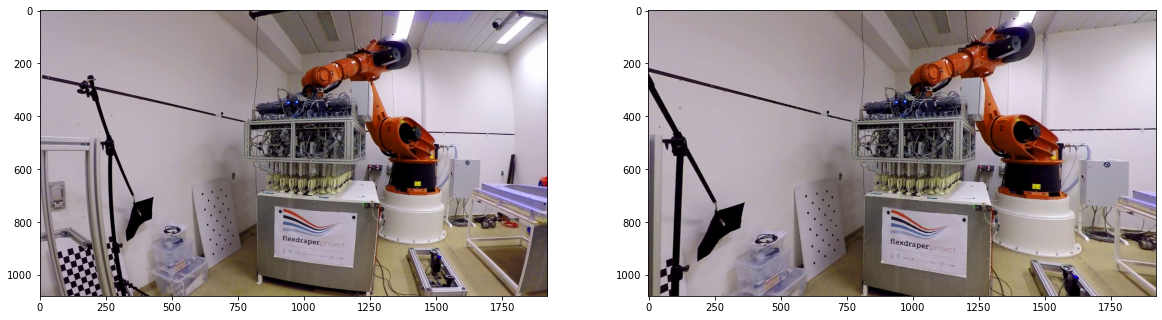

In [9]:
J = undistortImage(im, K, distortion)

fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(im)
ax[1].imshow(J);

## Homographies

### 2.5 Apply homography matrix

In [10]:
set1 = np.array([
    [1, 0, 2, 2],
    [1, 3, 3, 4],
    [1, 1, 1, 1],
])

H = np.array([
    [-2,  0, 1],
    [ 1, -2, 0],
    [ 0,  0, 3],
])

set2 = H @ set1
set2 = set2 / set2[2, :]
set2

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [11]:
set2

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

### 2.6 Estimate homography matrix

In [22]:
def hest_without_norm(q_before_H, q_after_H):
    """
    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    Return
    ------
    H: 3x3 numpy array
        Estimated homography matrix using the linear algorithm.
    """
    q1 = q_after_H
    q2 = q_before_H
    B = get_B(q1, q2)
    u, s, vh = np.linalg.svd(B)
    H = np.reshape(vh[-1, :], (3, 3), 'F')
    return H / H[2, 2]

def get_B(q1, q2):
    """
    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    """
    B = B_i(q1, q2, 0)
    for i in range(1, len(q1[0])):
        B = np.vstack((B, B_i(q1, q2, i)))
    return B

def B_i(q1, q2, i):
    return np.kron(
            q2[:,i],
            np.array([
                [ 0       , -1       ,  q1[1, i]],
                [ 1       ,  0       , -q1[0, i]],
                [-q1[1, i],  q1[0, i],  0       ],
            ])
        )
    

In [23]:
np.round(hest_without_norm(set1, set2) * 3, 2)

array([[-2.,  0.,  1.],
       [ 1., -2., -0.],
       [-0.,  0.,  3.]])

## 2.7

In [24]:
def normalize2d(Q):
    """Return the normalisation matrix and the normalised points.

    The mean of Tq is [0, 0] and the standard deviation is [1, 1].

    Parameter
    ---------
    Q: 2 x n or 3 x n numpy array
        set of points to normalise.
    Return
    ------
    Q: 3 x n numpy array
        set of points to normalise.
    """
    d, n = Q.shape
    if d == 2:
        Q = np.vstack(Q, np.ones(n))

    mean = np.mean(Q, axis=1)
    std = np.std(Q, axis=1)

    T = np.array([
        [1 / std[0], 0         , - mean[0] / std[0]],
        [0         , 1 / std[1], - mean[1] / std[1]],
        [0         , 0,            1               ],
    ])
    TQ = T @ Q
    return T, TQ / TQ[2]

In [25]:
normalize2d(set1)

(array([[ 1.20604538,  0.        , -1.50755672],
        [ 0.        ,  0.91766294, -2.52357307],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-0.30151134, -1.50755672,  0.90453403,  0.90453403],
        [-1.60591014,  0.22941573,  0.22941573,  1.14707867],
        [ 1.        ,  1.        ,  1.        ,  1.        ]]))

### 2.8 Use the normalisation in hest: modified 2.6

In [30]:
def hest(q_before_H, q_after_H):
    """
    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    Return
    ------
    H: 3x3 numpy array
        Estimated homography matrix using the linear algorithm.
    """
    T1, q1 = normalize2d(q_after_H)
    T2, q2 = normalize2d(q_before_H)
    B = get_B(q1, q2)
    u, s, vh = np.linalg.svd(B)
    H = np.reshape(vh[-1, :], (3, 3), 'F')
    H = np.linalg.inv(T1) @ H @ T2
    return H / H[2, 2]

### 2.9 Estimation of the homography on a large number of points

In [31]:
set1 = np.vstack((
    np.random.rand(2, 100),
    np.ones(100)
))

H = np.array([
    [-2,  0, 1],
    [ 1, -2, 0],
    [ 0,  0, 3],
])

set2 = H @ set1
set2 = set2 / set2[2, :]

hest(set1, set2) * 3

array([[-2.00000000e+00,  2.73313675e-16,  1.00000000e+00],
       [ 1.00000000e+00, -2.00000000e+00, -1.43795447e-16],
       [-1.28248672e-15, -1.77094435e-17,  3.00000000e+00]])